In [179]:
# Imports

# Standard library
import os
import random
import warnings
import json
import base64
from io import BytesIO

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms

# Image processing
from PIL import Image, ImageOps, ImageFilter

# Cloud satellite image generation
import satellite_cloud_generator as scg

# Progress bar
from tqdm import tqdm

# Hugging Face Datasets
from datasets import load_dataset, Dataset

# OpenAI API
from openai import OpenAI

# Machine learning utilities
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")

In [171]:
# Parameters and Constants
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

TARGET_SIZE = (224, 224)
DATASET_NAME = 'jbourcier/fgsc23'
IMAGE_COL    = 'image'                       # HF column name for images
LABEL_COL    = 'label'                       # HF column name for labels
CLASS_COL    = ['class_name']                # HF column name for class names
DUPLICATION_THRESHOLD = 0.95
IMG_SIZE     = (224, 224)
APPLY_BLUR = True               # toggle Gaussian blur
BLUR_RADIUS_RANGE = (0.0, 2.0)
APPLY_HAZE = True               # toggle white‐haze overlay
HAZE_ALPHA_RANGE = (0.0, 0.4)
MODEL_NAMES = ["resnet18", "efficientnet_b0", "mobilenet_v3_large"]
BATCH_SIZE   = 32
NUM_EPOCHS   = 20
LEARNING_RATE = 1e-4
NUM_WORKERS = 0
DEVICE       = torch.device('cpu')

In [3]:
# Load Dataset
ds: Dataset = load_dataset(DATASET_NAME, split="train")

# Display Dataset Information
print(ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 4080
})


In [4]:
# Mapping integer labels (0–22) to human-readable ship class names from Zhang et al. (2020)
label_map = {
    0:  "Non-ship",
    1:  "Aircraft carrier",
    12:  "Destroyer",
    16:  "Landing craft",
    17:  "Frigate",
    18:  "Amphibious transport dock",
    19:  "Cruiser",
    20:  "Tarawa-class amphibious assault ship",
    21:  "Amphibious assault ship",
    22:  "Command ship",
    2: "Submarine",
    3: "Medical ship",
    4: "Combat boat",
    5: "Auxiliary ship",
    6: "Container ship",
    7: "Car carrier",
    8: "Hovercraft",
    9: "Bulk carrier",
    10: "Oil tanker",
    11: "Fishing boat",
    13: "Passenger ship",
    14: "Liquefied gas ship",
    15: "Barge"
}

# Add a new column 'class_name' to the dataset with human-readable labels
def map_label(example):
    example['class_name'] = label_map.get(example['label'], "Unknown")
    return example

ds = ds.map(map_label)

# Display Dataset Information
print(ds)

Dataset({
    features: ['image', 'label', 'class_name'],
    num_rows: 4080
})


Class distribution (sorted):
class_name
Destroyer                               542
Non-ship                                484
Bulk carrier                            343
Frigate                                 295
Cruiser                                 293
Submarine                               238
Auxiliary ship                          225
Aircraft carrier                        166
Oil tanker                              165
Amphibious assault ship                 154
Combat boat                             143
Hovercraft                              120
Landing craft                           108
Fishing boat                            102
Container ship                          100
Liquefied gas ship                       94
Amphibious transport dock                90
Command ship                             89
Tarawa-class amphibious assault ship     88
Passenger ship                           88
Car carrier                              72
Barge                               

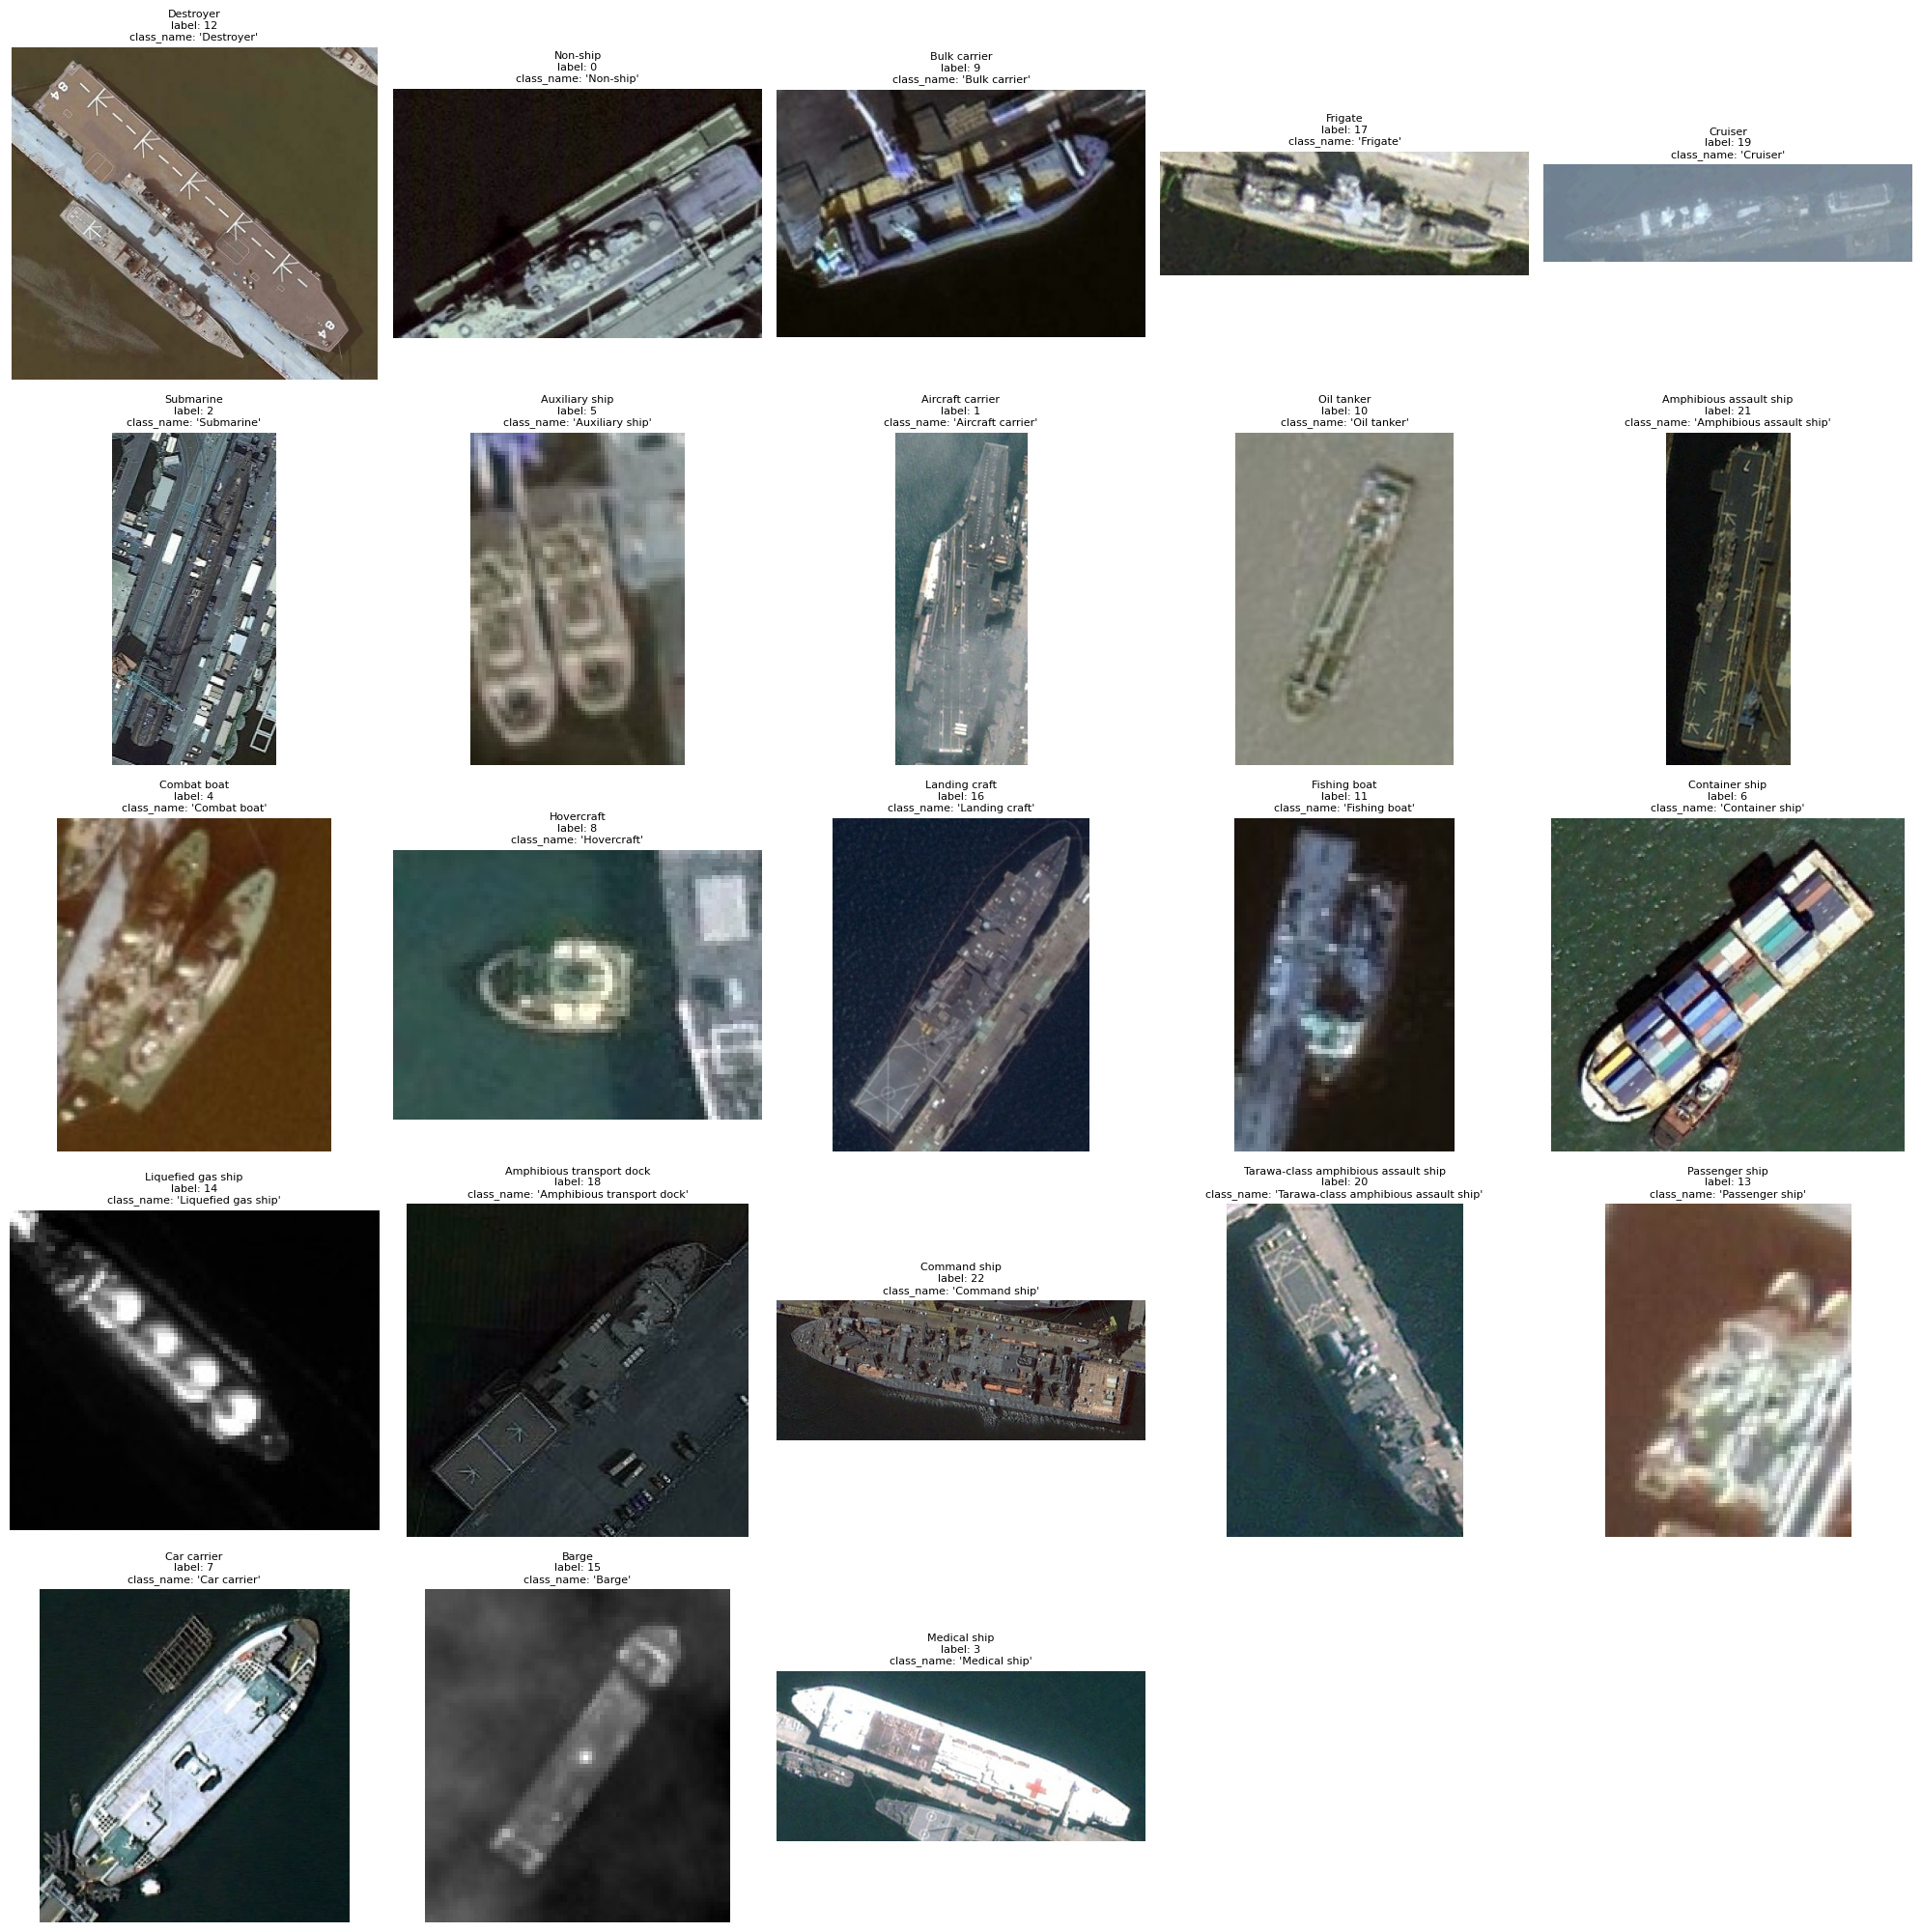

In [5]:
# Inspect Dataset

# Print class distribution sorted by sample count
class_counts = ds.to_pandas()['class_name'].value_counts().sort_values(ascending=False)
print("Class distribution (sorted):")
print(class_counts)

def plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5):
    """
    Plots one image per class in a grid, with all features printed above each image.

    Args:
        ds: Dataset object.
        class_counts: Pandas Series of class counts, sorted.
        n_rows: Number of rows in grid.
        n_cols: Number of columns in grid.
    """
    n_classes = len(class_counts)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    for i, class_name in enumerate(class_counts.index):
        row, col = divmod(i, n_cols)
        ax = axes[row, col]
        idx = int(ds.to_pandas().query("class_name == @class_name").index[0])
        example = ds[idx]
        img = example['image']

        # Prepare feature string
        feature_str = "\n".join([f'{k}: {repr(v)}' for k, v in example.items() if k != 'image'])

        ax.imshow(img)
        ax.set_title(f"{class_name}\n{feature_str}", fontsize=8)
        ax.axis('off')

    # Hide unused subplots if any
    for j in range(n_classes, n_rows * n_cols):
        row, col = divmod(j, n_cols)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5)

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3999 [00:00<?, ? examples/s]

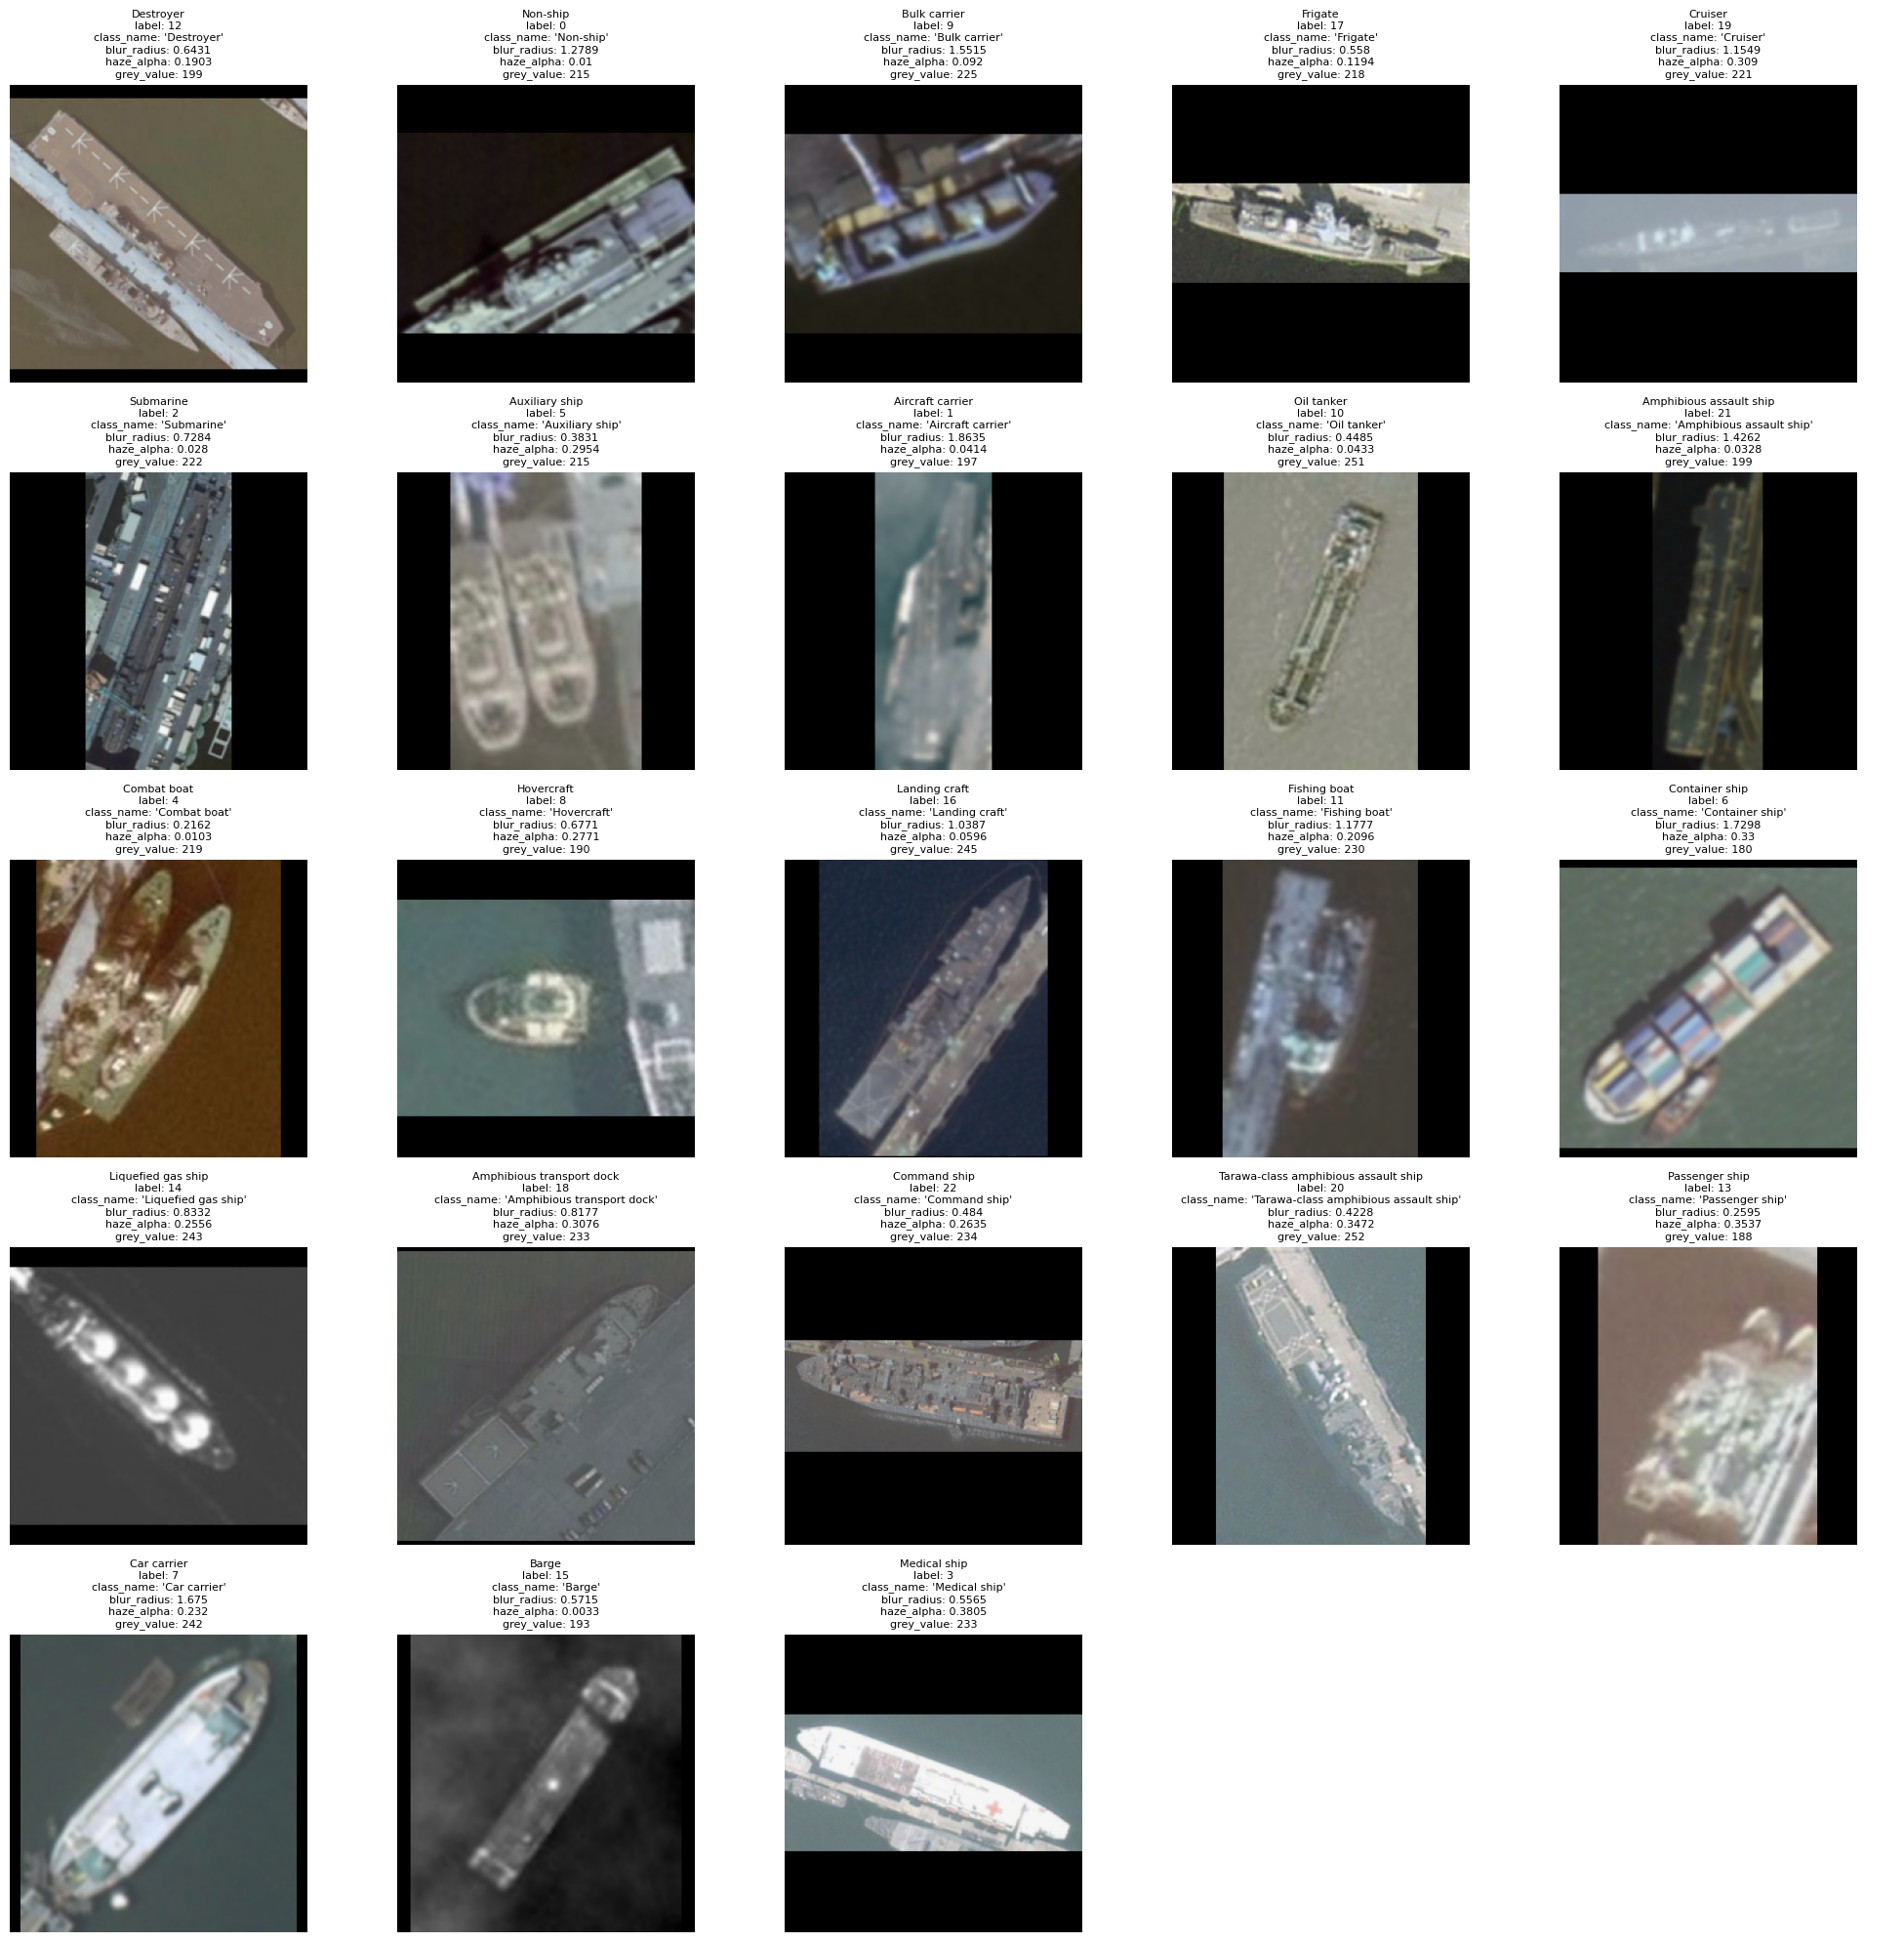

In [7]:
# Apply Distortions, Resizing, and Padding, and save distortion parameters

def preprocess(example):
    # 1) load & ensure RGB
    img = example["image"].convert("RGB")

    # 2) resize to IMG_SIZE
    iw, ih = img.size
    tw, th = IMG_SIZE
    scale = min(tw / iw, th / ih)
    nw, nh = int(iw * scale), int(ih * scale)
    img_resized = img.resize((nw, nh), Image.LANCZOS)

    # 3) optional Gaussian blur
    blur_radius = None
    if APPLY_BLUR:
        blur_radius = random.uniform(*BLUR_RADIUS_RANGE)
        img_resized = img_resized.filter(ImageFilter.GaussianBlur(blur_radius))

    # 4) optional white haze (blend with white overlay)
    haze_alpha = None
    grey_value = None
    if APPLY_HAZE:
        haze_alpha = random.uniform(*HAZE_ALPHA_RANGE)
        grey_value = random.randint(180, 255)
        grey_overlay = Image.new("RGB", img_resized.size, (grey_value, grey_value, grey_value))
        img_resized = Image.blend(img_resized, grey_overlay, alpha=haze_alpha)

    # 5) pad to IMG_SIZE
    pad_left   = (tw - nw) // 2
    pad_top    = (th - nh) // 2
    pad_right  = tw - nw - pad_left
    pad_bottom = th - nh - pad_top
    img_padded = ImageOps.expand(img_resized,
                                 border=(pad_left, pad_top, pad_right, pad_bottom),
                                 fill=(0, 0, 0))

    img_out = img_padded

    # 6) overwrite and return, add distortion parameters
    example["image"] = img_out
    example["blur_radius"] = round(blur_radius, 4) if blur_radius is not None else None
    example["haze_alpha"] = round(haze_alpha, 4) if haze_alpha is not None else None
    example["grey_value"] = grey_value
    return example

# --- Apply to your Dataset ---
ds = ds.map(preprocess, batched=False)

# Persist to disk in the same Arrow+image format:
ds.save_to_disk("data/preprocessed_dataset/")

# Save metadata (labels + distortion parameters) to CSV
metadata_df = ds.to_pandas()[["label", "class_name", "blur_radius", "haze_alpha", "grey_value"]]
metadata_path = os.path.join("data/", "preprocessed_metadata.csv")
metadata_df.to_csv(metadata_path, index=False)

# Plot one image per class in a grid
plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5)

In [238]:
# Compute image qualities via OpenAI vision-capable model

# 0) Set API key
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 1) Helper to convert PIL image to data-URL base64
def pil_to_data_uri(img):
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{b64}"

# 2) System prompt
PROMPT = """
You are an expert satellite/UAV imagery quality assessor whose job is to support automated ship classification.  
The downstream classifier must distinguish among many military and civilian ship types—aircraft carriers, destroyers, frigates, container ships, etc.—some of which look very similar at low resolution or under blur.

For each image I show you (always containing a ship), output exactly one JSON field:
  • "quality": a float between 0.00 and 1.00 (1.00 = perfectly clear for distinguishing ship classes, 0.00 = totally unusable).

Penalize any of these degradations:
- Blur or defocus
- Sensor noise or grain
- JPEG/block compression artifacts
- Atmospheric haze or low contrast
- Clouds or partial occlusion

**Use at least two decimal places, and vary your answers**—do not pick the same value repeatedly.  Spread your scores throughout the range according to perceived quality.  

Do not output anything else, only the JSON in this exact format: {"quality": value}
"""

# 3) Map function to call OpenAI and append quality
def get_quality(example):
    # encode PIL image to data URI
    data_uri = pil_to_data_uri(example["image"])
    # build messages
    messages = [
        {
            "role": "system",
            "content": PROMPT
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": data_uri
                    },
                }
            ]
        }
    ]

    # call chat completion
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        temperature=1.0,
        max_tokens=100
    )
    # parse JSON
    try:
        content = response.choices[0].message.content.strip()
        data = json.loads(content)
        quality = float(data["quality"])
        return quality
    except Exception as e:
        return None

# # Compute OpenAI quality score for all images in ds and update dataset
# image_qualities = []
# for idx in tqdm(range(len(ds)), desc="Scoring 100 random images"):
#     example = {"image": ds[idx]["image"], "idx": idx}
#     result = get_quality(example)
#     retries = 0
#     while result is None and retries < 50:
#         result = get_quality(example)
#         retries += 1
#     if result is not None:
#         image_qualities.append(result)
#     else:
#         print(f"Failed to get quality for idx {idx} after {retries+1} attempts")
#         image_qualities.append(0.5)
    
# # Add image_quality feature to ds
# ds = ds.add_column("image_quality", image_qualities)

# # Save all qualities to CSV
# df_q = pd.DataFrame(image_qualities)
# df_q.columns = ["image_quality"]
# df_q.index.name = "idx"
# df_q.to_csv("data/image_qualities.csv", index=True, header=["image_quality"])
# print("Saved all qualities to image_qualities.csv")

# # Save enriched dataset
# ds.save_to_disk("data/preprocessed_dataset_with_quality/")

# # Plot histogram of image qualities
# plt.figure(figsize=(6, 4))
# plt.hist(image_qualities, bins=25, color='skyblue', edgecolor='black')
# plt.xlabel('Image Quality')
# plt.ylabel('Count')
# plt.title('Histogram of Image Qualities')
# plt.xlim(0, 1)
# plt.show()

# # Plot one image per class in a grid
# plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5)

Saving the dataset (0/1 shards):   0%|          | 0/2399 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/800 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/800 [00:00<?, ? examples/s]

Train set size: 2399
Validation set size: 800
Test set size: 800


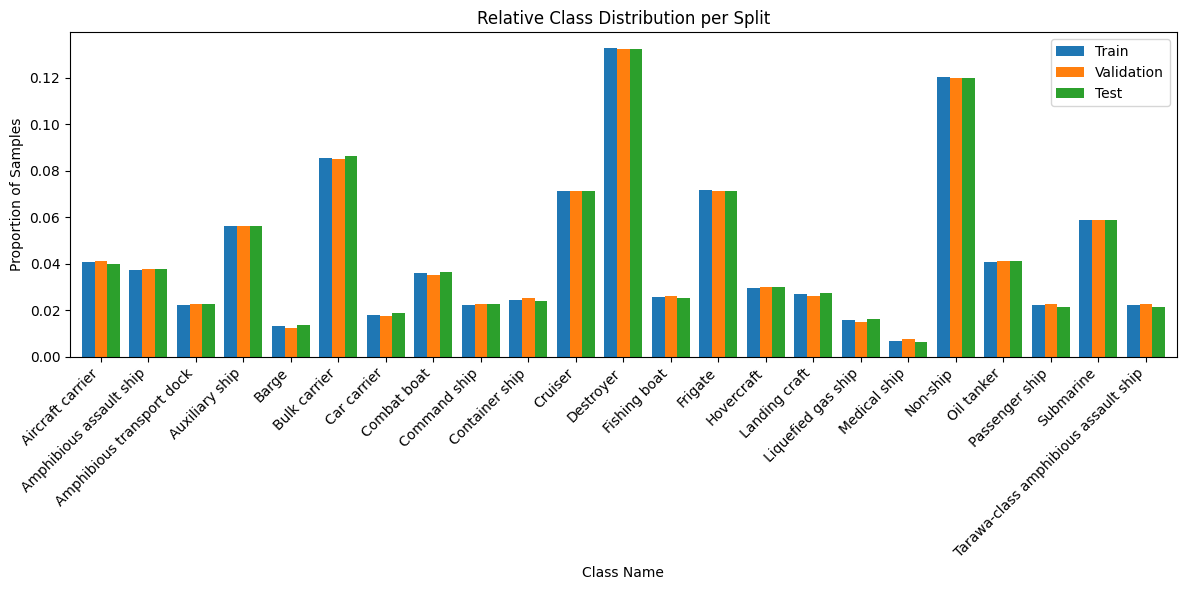

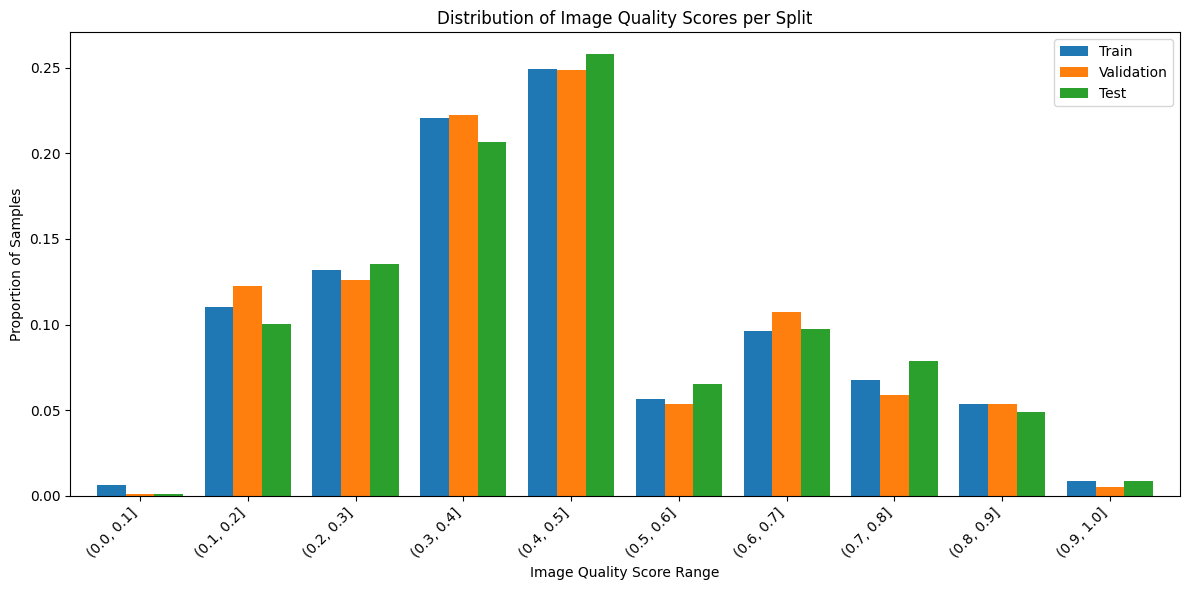

In [162]:
# Define split ratios for sufficient calibration and testing
val_ratio = 0.2
test_ratio = 0.2

# Get labels array for stratification
labels = ds.to_pandas()['label'].values

# First stratified split: train vs. (val+test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio))
train_idx, temp_idx = next(sss.split(np.zeros(len(labels)), labels))

# Second stratified split: within the temp set, separate val and test
temp_labels = labels[temp_idx]
sss2 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=test_ratio / (val_ratio + test_ratio),
)
val_sub_idx, test_sub_idx = next(sss2.split(np.zeros(len(temp_labels)), temp_labels))
val_idx = temp_idx[val_sub_idx]
test_idx = temp_idx[test_sub_idx]

# Create and save splits
ds_train = ds.select(train_idx)
ds_val   = ds.select(val_idx)
ds_test  = ds.select(test_idx)

ds_train.save_to_disk("data/train_dataset/")
ds_val.save_to_disk("data/val_dataset/")
ds_test.save_to_disk("data/test_dataset/")

# Print split sizes
print(f"Train set size: {len(ds_train)}")
print(f"Validation set size: {len(ds_val)}")
print(f"Test set size: {len(ds_test)}")

# Compute relative class distributions for each split
dist_train = ds_train.to_pandas()['class_name'].value_counts(normalize=True).sort_index()
dist_val   = ds_val.to_pandas()['class_name'].value_counts(normalize=True).sort_index()
dist_test  = ds_test.to_pandas()['class_name'].value_counts(normalize=True).sort_index()

# Combine into a single DataFrame
dist_df = pd.DataFrame({
    'Train': dist_train,
    'Validation': dist_val,
    'Test': dist_test
}).fillna(0)

# Plot grouped bar chart of relative frequencies
ax = dist_df.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8
)
ax.set_xlabel('Class Name')
ax.set_ylabel('Proportion of Samples')
ax.set_title('Relative Class Distribution per Split')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('results', 'relative_class_dist.svg'), format='svg')
plt.show()

# Plot distribution of image quality scores per split
# Bin quality scores into deciles
bins = np.linspace(0, 1, 11)
q_train = pd.cut(ds_train.to_pandas()['image_quality'], bins=bins)
q_val   = pd.cut(ds_val.to_pandas()['image_quality'], bins=bins)
q_test  = pd.cut(ds_test.to_pandas()['image_quality'], bins=bins)

dist_q_train = q_train.value_counts(normalize=True).sort_index()
dist_q_val   = q_val.value_counts(normalize=True).sort_index()
dist_q_test  = q_test.value_counts(normalize=True).sort_index()

dist_q_df = pd.DataFrame({
    'Train': dist_q_train,
    'Validation': dist_q_val,
    'Test': dist_q_test
}).fillna(0)

ax = dist_q_df.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8
)
ax.set_xlabel('Image Quality Score Range')
ax.set_ylabel('Proportion of Samples')
ax.set_title('Distribution of Image Quality Scores per Split')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('results', 'image_quality_dist.svg'), format='svg')
plt.show()

In [164]:
# DataLoaders
# No transform is applied here, as the images are already preprocessed and we would need new quality scores for any new images.
# Define a custom collate function to handle the dataset format

def collate_fn(batch):
    imgs = [transform(ex["image"].convert("RGB")) for ex in batch]
    labels = [ex["label"] for ex in batch]
    imgs = torch.stack(imgs).to(DEVICE)
    labels = torch.tensor(labels, dtype=torch.long, device=DEVICE)
    return imgs, labels

# compute class frequencies on the training set
train_labels = ds_train.to_pandas()['label'].values
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts

# assign each sample its class weight
sample_weights = class_weights[train_labels]
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoaders
train_loader = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    ds_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    ds_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}, Validation: {len(val_loader)}, Test: {len(test_loader)}")

Train batches: 75, Validation: 25, Test: 25


In [165]:
# Function to get model and prepare it for classification depending on the number of classes

def get_model(name, num_classes):
    if name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "mobilenet_v3_large":
        model = models.mobilenet_v3_large(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return model


=== Training resnet18 on cpu ===


Epoch 1/20 - resnet18 val_acc: 0.5038


Epoch 2/20 - resnet18 val_acc: 0.5875


Epoch 3/20 - resnet18 val_acc: 0.6637


Epoch 4/20 - resnet18 val_acc: 0.6725


Epoch 5/20 - resnet18 val_acc: 0.6787


Epoch 6/20 - resnet18 val_acc: 0.6963


Epoch 7/20 - resnet18 val_acc: 0.6900


Epoch 8/20 - resnet18 val_acc: 0.7025


Epoch 9/20 - resnet18 val_acc: 0.7037


Epoch 10/20 - resnet18 val_acc: 0.7063


Epoch 11/20 - resnet18 val_acc: 0.7037


Epoch 12/20 - resnet18 val_acc: 0.7063


Epoch 13/20 - resnet18 val_acc: 0.7087


Epoch 14/20 - resnet18 val_acc: 0.7075


Epoch 15/20 - resnet18 val_acc: 0.7175


Epoch 16/20 - resnet18 val_acc: 0.7163


Epoch 17/20 - resnet18 val_acc: 0.7137


Epoch 18/20 - resnet18 val_acc: 0.7150


Epoch 19/20 - resnet18 val_acc: 0.7150


Epoch 20/20 - resnet18 val_acc: 0.7188
Saved best resnet18 (val_acc=0.7188) to models\best_resnet18_epoch0.7188.pth


Test accuracy for resnet18: 0.7175
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        96
           1       0.75      0.94      0.83        32
           2       0.87      0.85      0.86        47
           3       0.80      0.80      0.80         5
           4       0.82      0.79      0.81        29
           5       0.66      0.60      0.63        45
           6       0.80      0.63      0.71        19
           7       0.87      0.87      0.87        15
           8       1.00      0.96      0.98        24
           9       0.57      0.71      0.63        69
          10       0.64      0.55      0.59        33
          11       0.53      0.40      0.46        20
          12       0.64      0.80      0.71       106
          13       0.64      0.53      0.58        17
          14       0.93      1.00      0.96        13
          15       1.00      1.00      1.00        11
          16       0.67      0.45      0.54   

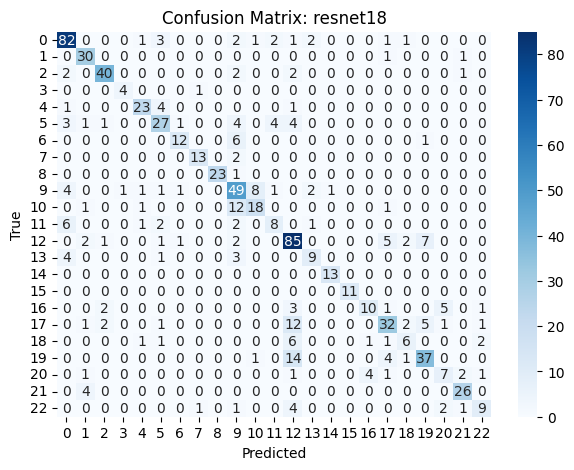


=== Training efficientnet_b0 on cpu ===


Epoch 1/20 - efficientnet_b0 val_acc: 0.3100


Epoch 2/20 - efficientnet_b0 val_acc: 0.4587


Epoch 3/20 - efficientnet_b0 val_acc: 0.5900


Epoch 4/20 - efficientnet_b0 val_acc: 0.6462


Epoch 5/20 - efficientnet_b0 val_acc: 0.7025


Epoch 6/20 - efficientnet_b0 val_acc: 0.7512


Epoch 7/20 - efficientnet_b0 val_acc: 0.7625


Epoch 8/20 - efficientnet_b0 val_acc: 0.7775


Epoch 9/20 - efficientnet_b0 val_acc: 0.7700


Epoch 10/20 - efficientnet_b0 val_acc: 0.7625


Epoch 11/20 - efficientnet_b0 val_acc: 0.7650


Epoch 12/20 - efficientnet_b0 val_acc: 0.7825


Epoch 13/20 - efficientnet_b0 val_acc: 0.7800


Epoch 14/20 - efficientnet_b0 val_acc: 0.7688


Epoch 15/20 - efficientnet_b0 val_acc: 0.7762


Epoch 16/20 - efficientnet_b0 val_acc: 0.7700


Epoch 17/20 - efficientnet_b0 val_acc: 0.7738


Epoch 18/20 - efficientnet_b0 val_acc: 0.7562


Epoch 19/20 - efficientnet_b0 val_acc: 0.7700


Epoch 20/20 - efficientnet_b0 val_acc: 0.7712
Saved best efficientnet_b0 (val_acc=0.7825) to models\best_efficientnet_b0_epoch0.7825.pth


Test accuracy for efficientnet_b0: 0.7863
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        96
           1       0.94      1.00      0.97        32
           2       0.89      0.87      0.88        47
           3       1.00      1.00      1.00         5
           4       0.81      0.86      0.83        29
           5       0.61      0.62      0.62        45
           6       0.62      0.79      0.70        19
           7       0.88      0.93      0.90        15
           8       1.00      0.96      0.98        24
           9       0.66      0.58      0.62        69
          10       0.77      0.70      0.73        33
          11       0.50      0.50      0.50        20
          12       0.83      0.89      0.86       106
          13       0.67      0.59      0.62        17
          14       1.00      0.92      0.96        13
          15       0.92      1.00      0.96        11
          16       0.57      0.73      

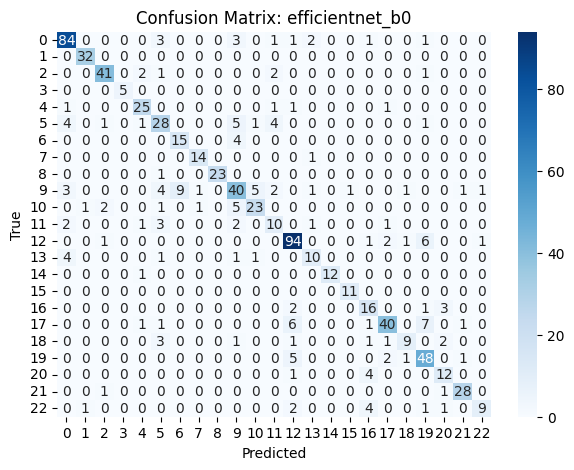


=== Training mobilenet_v3_large on cpu ===


Epoch 1/20 - mobilenet_v3_large val_acc: 0.3063


Epoch 2/20 - mobilenet_v3_large val_acc: 0.4938


Epoch 3/20 - mobilenet_v3_large val_acc: 0.5938


Epoch 4/20 - mobilenet_v3_large val_acc: 0.6663


Epoch 5/20 - mobilenet_v3_large val_acc: 0.6937


Epoch 6/20 - mobilenet_v3_large val_acc: 0.7100


Epoch 7/20 - mobilenet_v3_large val_acc: 0.6900


Epoch 8/20 - mobilenet_v3_large val_acc: 0.7163


Epoch 9/20 - mobilenet_v3_large val_acc: 0.7225


Epoch 10/20 - mobilenet_v3_large val_acc: 0.7262


Epoch 11/20 - mobilenet_v3_large val_acc: 0.7288


Epoch 12/20 - mobilenet_v3_large val_acc: 0.7137


Epoch 13/20 - mobilenet_v3_large val_acc: 0.7087


Epoch 14/20 - mobilenet_v3_large val_acc: 0.7375


Epoch 15/20 - mobilenet_v3_large val_acc: 0.7137


Epoch 16/20 - mobilenet_v3_large val_acc: 0.7512


Epoch 17/20 - mobilenet_v3_large val_acc: 0.7388


Epoch 18/20 - mobilenet_v3_large val_acc: 0.7488


Epoch 19/20 - mobilenet_v3_large val_acc: 0.7350


Epoch 20/20 - mobilenet_v3_large val_acc: 0.7425
Saved best mobilenet_v3_large (val_acc=0.7512) to models\best_mobilenet_v3_large_epoch0.7512.pth


Test accuracy for mobilenet_v3_large: 0.7638
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        96
           1       0.89      0.97      0.93        32
           2       0.82      0.87      0.85        47
           3       1.00      0.80      0.89         5
           4       0.79      0.79      0.79        29
           5       0.62      0.71      0.66        45
           6       1.00      0.79      0.88        19
           7       0.88      0.93      0.90        15
           8       1.00      1.00      1.00        24
           9       0.84      0.70      0.76        69
          10       0.71      0.76      0.74        33
          11       0.46      0.55      0.50        20
          12       0.75      0.83      0.79       106
          13       0.65      0.76      0.70        17
          14       1.00      1.00      1.00        13
          15       1.00      0.91      0.95        11
          16       0.62      0.73   

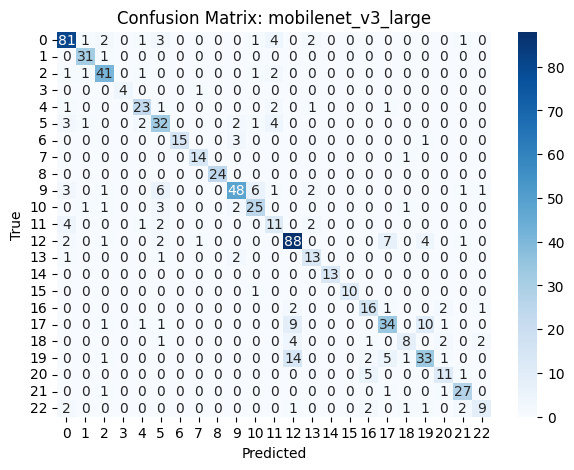


=== Summary of All Models ===
resnet18: val_acc=0.7188, test_acc=0.7175, model saved at models\best_resnet18_epoch0.7188.pth
efficientnet_b0: val_acc=0.7825, test_acc=0.7863, model saved at models\best_efficientnet_b0_epoch0.7825.pth
mobilenet_v3_large: val_acc=0.7512, test_acc=0.7638, model saved at models\best_mobilenet_v3_large_epoch0.7512.pth


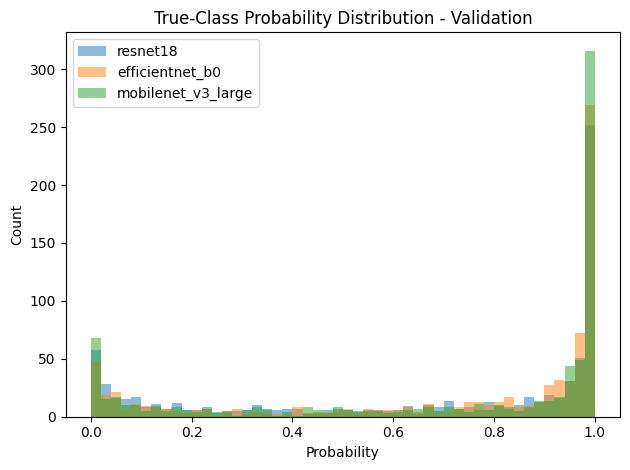

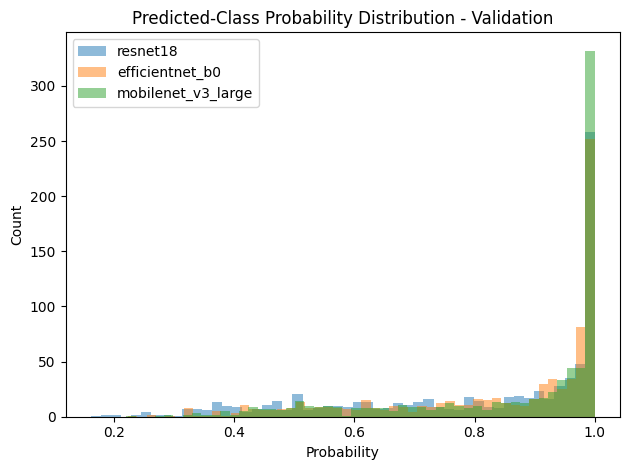

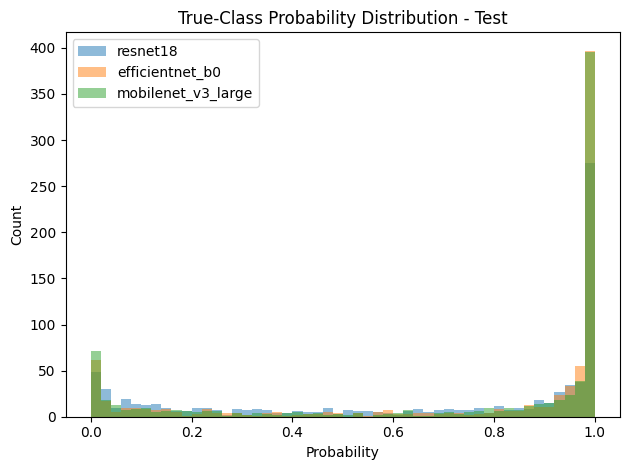

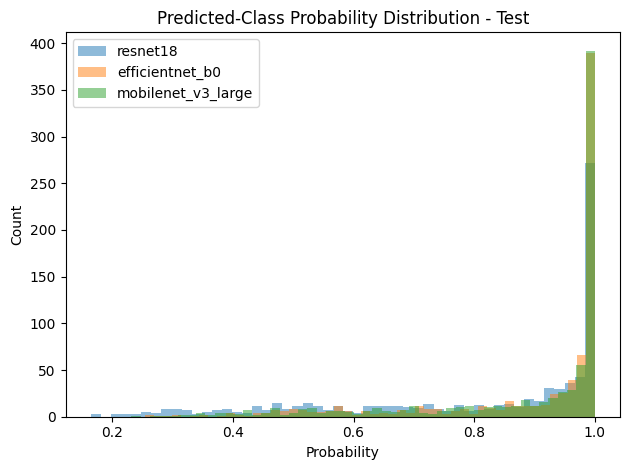

In [172]:
# Data loaders (assumed defined elsewhere): train_loader, val_loader, test_loader
# label_map defined previously; determines num_classes
num_classes = len(label_map)

# To store per-model summaries and probability distributions
history = {}
prob_dists = {}

for name in MODEL_NAMES:
    print(f"\n=== Training {name} on {DEVICE} ===")
    model = get_model(name, num_classes).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    best_epoch_acc = 0.0
    best_state = None
    val_records = {'preds': [], 'labels': [], 'probs': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        # Training
        model.train()
        train_iter = tqdm(train_loader, desc=f"[{name}] Train Epoch {epoch}/{NUM_EPOCHS}", leave=False)
        for imgs, labels in train_iter:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_iter = tqdm(val_loader, desc=f"[{name}] Val Epoch {epoch}/{NUM_EPOCHS}", leave=False)
        all_preds, all_labels, all_probs = [], [], []
        with torch.no_grad():
            for imgs, labels in val_iter:
                imgs = imgs.to(DEVICE)
                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)
                preds = probs.argmax(dim=1)
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.tolist())
                all_probs.extend(probs.cpu().tolist())

        val_acc = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch}/{NUM_EPOCHS} - {name} val_acc: {val_acc:.4f}")

        # If best for this model, save state
        if val_acc > best_epoch_acc:
            best_epoch_acc = val_acc
            best_state = model.state_dict()
            val_records = {'preds': all_preds, 'labels': all_labels, 'probs': all_probs}

    # Save best model
    model_filename = f"best_{name}_epoch{best_epoch_acc:.4f}.pth"
    model_path = os.path.join('models', model_filename)
    torch.save(best_state, model_path)
    print(f"Saved best {name} (val_acc={best_epoch_acc:.4f}) to {model_path}")

    # Test with best weights
    model.load_state_dict(best_state)
    model.eval()
    test_preds, test_labels, test_probs = [], [], []
    test_iter = tqdm(test_loader, desc=f"[{name}] Testing", leave=False)
    with torch.no_grad():
        for imgs, labels in test_iter:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)
            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(labels.tolist())
            test_probs.extend(probs.cpu().tolist())

    test_acc = accuracy_score(test_labels, test_preds)
    print(f"Test accuracy for {name}: {test_acc:.4f}")
    print(classification_report(test_labels, test_preds))

    # Plot and save confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join('results', f'confusion_matrix_{name}.svg'), format='svg')
    plt.show()

    # Save confusion matrix as CSV
    cm_df = pd.DataFrame(cm, index=label_map.values(), columns=label_map.values())
    cm_csv = os.path.join('results', f"confusion_matrix_{name}.csv")
    cm_df.to_csv(cm_csv, index=True)

    # Save class probabilities + predictions
    cols = [f"prob_{i}" for i in range(num_classes)]
    val_df = pd.DataFrame(val_records['probs'], columns=cols)
    val_df['true'] = val_records['labels']
    val_df['pred'] = val_records['preds']
    val_csv = os.path.join('results', f"val_{name}_class_probs.csv")
    val_df.to_csv(val_csv, index=False)

    test_df = pd.DataFrame(test_probs, columns=cols)
    test_df['true'] = test_labels
    test_df['pred'] = test_preds
    test_csv = os.path.join('results', f"test_{name}_class_probs.csv")
    test_df.to_csv(test_csv, index=False)

    # Compute true-class and predicted-class probability distributions
    true_prob_val = [val_records['probs'][i][label] for i, label in enumerate(val_records['labels'])]
    pred_prob_val = [max(probs) for probs in val_records['probs']]
    true_prob_test = [test_probs[i][label] for i, label in enumerate(test_labels)]
    pred_prob_test = [max(probs) for probs in test_probs]
    prob_dists[name] = {
        'val_true': true_prob_val,
        'val_pred': pred_prob_val,
        'test_true': true_prob_test,
        'test_pred': pred_prob_test
    }

    # Record summary
    history[name] = {
        'best_val_acc': best_epoch_acc,
        'best_model_file': model_path,
        'test_acc': test_acc,
        'val_probs_csv': val_csv,
        'test_probs_csv': test_csv
    }

# Summarize all models
print("\n=== Summary of All Models ===")
for name, stats in history.items():
    print(f"{name}: val_acc={stats['best_val_acc']:.4f}, test_acc={stats['test_acc']:.4f}, model saved at {stats['best_model_file']}")

# Plot and save separate histograms
# Validation true-class probabilities
plt.figure()
for name, d in prob_dists.items():
    plt.hist(d['val_true'], bins=50, alpha=0.5, label=name)
plt.title('True-Class Probability Distribution - Validation')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('results', 'val_true_prob_dist.svg'), format='svg')
plt.show()

# Validation predicted-class probabilities
plt.figure()
for name, d in prob_dists.items():
    plt.hist(d['val_pred'], bins=50, alpha=0.5, label=name)
plt.title('Predicted-Class Probability Distribution - Validation')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('results', 'val_pred_prob_dist.svg'), format='svg')
plt.show()

# Test true-class probabilities
plt.figure()
for name, d in prob_dists.items():
    plt.hist(d['test_true'], bins=50, alpha=0.5, label=name)
plt.title('True-Class Probability Distribution - Test')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('results', 'test_true_prob_dist.svg'), format='svg')
plt.show()

# Test predicted-class probabilities
plt.figure()
for name, d in prob_dists.items():
    plt.hist(d['test_pred'], bins=50, alpha=0.5, label=name)
plt.title('Predicted-Class Probability Distribution - Test')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('results','test_pred_prob_dist.svg'), format='svg')
plt.show()

resnet18 VAL - Correct: avg pred_prob=0.8684, avg quality=0.4222
resnet18 VAL - Incorrect: avg pred_prob=0.6336, avg quality=0.4472


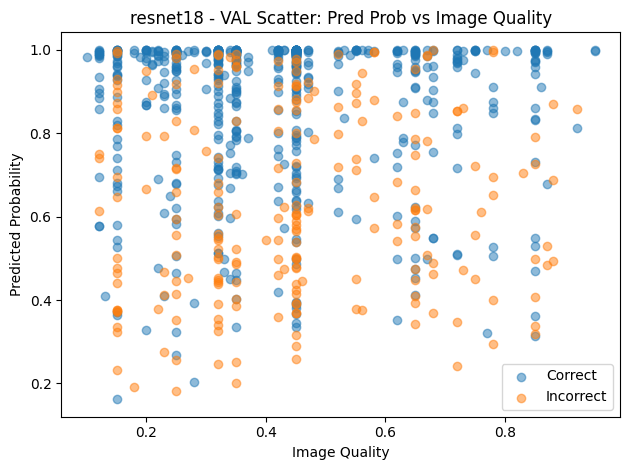

efficientnet_b0 VAL - Correct: avg pred_prob=0.8876, avg quality=0.4301
efficientnet_b0 VAL - Incorrect: avg pred_prob=0.6754, avg quality=0.4263


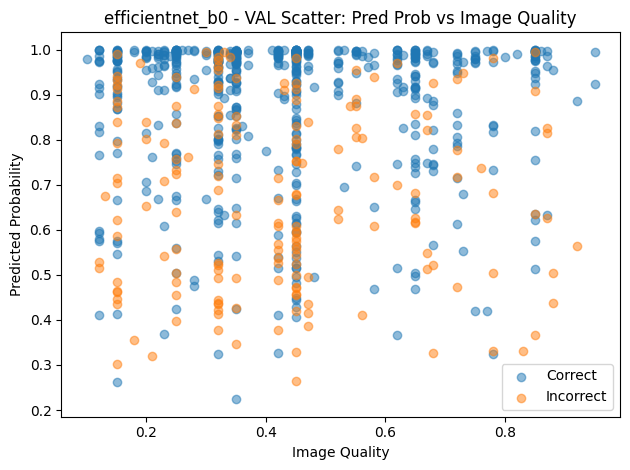

mobilenet_v3_large VAL - Correct: avg pred_prob=0.9022, avg quality=0.4225
mobilenet_v3_large VAL - Incorrect: avg pred_prob=0.7232, avg quality=0.4497


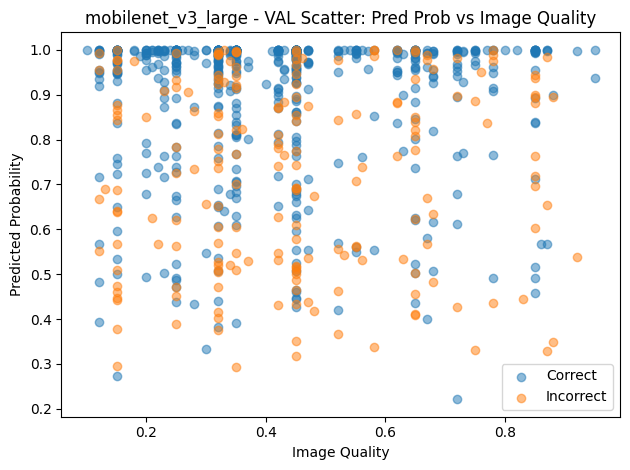

resnet18 TEST - Correct: avg pred_prob=0.8773, avg quality=0.4404
resnet18 TEST - Incorrect: avg pred_prob=0.6139, avg quality=0.4404


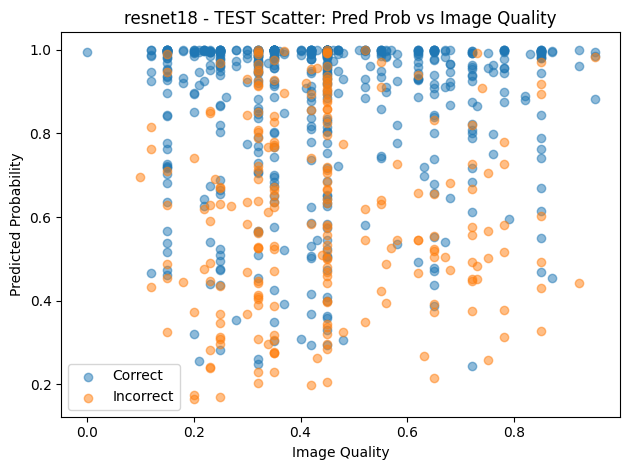

efficientnet_b0 TEST - Correct: avg pred_prob=0.9370, avg quality=0.4431
efficientnet_b0 TEST - Incorrect: avg pred_prob=0.7280, avg quality=0.4306


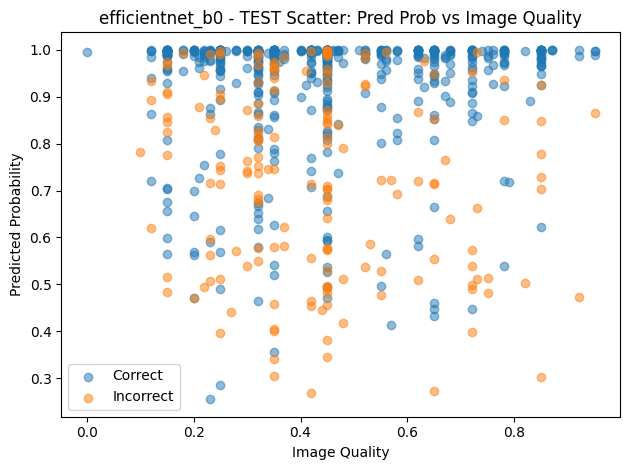

mobilenet_v3_large TEST - Correct: avg pred_prob=0.9352, avg quality=0.4439
mobilenet_v3_large TEST - Incorrect: avg pred_prob=0.7144, avg quality=0.4290


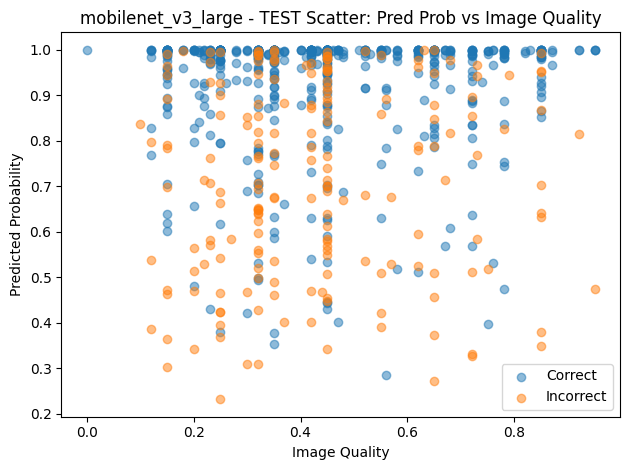

In [175]:
for split, ds in [('val', ds_val), ('test', ds_test)]:
    for name in MODEL_NAMES:
        csv_path = os.path.join('results', f"{split}_{name}_class_probs.csv")
        df = pd.read_csv(csv_path)

        # Predicted probability is the max over all class probabilities
        prob_cols = [c for c in df.columns if c.startswith('prob_')]
        df['pred_prob'] = df[prob_cols].max(axis=1)

        # Extract image quality and correctness
        qualities = [ds[i]['image_quality'] for i in range(len(ds))]
        df['image_quality'] = qualities
        df['correct'] = df['true'] == df['pred']

        # Compute and print average stats
        mask = df['correct']
        mean_pred_correct = df.loc[mask, 'pred_prob'].mean()
        mean_pred_incorrect = df.loc[~mask, 'pred_prob'].mean()
        mean_qual_correct = df.loc[mask, 'image_quality'].mean()
        mean_qual_incorrect = df.loc[~mask, 'image_quality'].mean()
        print(f"{name} {split.upper()} - Correct: avg pred_prob={mean_pred_correct:.4f}, avg quality={mean_qual_correct:.4f}")
        print(f"{name} {split.upper()} - Incorrect: avg pred_prob={mean_pred_incorrect:.4f}, avg quality={mean_qual_incorrect:.4f}")

        # Plot and save scatter with color coding
        plt.figure()
        # Correctly classified samples
        mask = df['correct']
        plt.scatter(df.loc[mask, 'image_quality'],
                    df.loc[mask, 'pred_prob'],
                    alpha=0.5, label='Correct')
        # Misclassified samples
        plt.scatter(df.loc[~mask, 'image_quality'],
                    df.loc[~mask, 'pred_prob'],
                    alpha=0.5, label='Incorrect')

        plt.title(f"{name} - {split.upper()} Scatter: Pred Prob vs Image Quality")
        plt.xlabel('Image Quality')
        plt.ylabel('Predicted Probability')
        plt.legend()
        plt.tight_layout()

        svg_path = os.path.join('results', f"{name}_{split}_scatter.svg")
        plt.savefig(svg_path, format='svg')
        plt.show()

In [178]:
# == Class-wise Correctness and Quality Analysis ==
for split, ds in [('val', ds_val), ('test', ds_test)]:
    for name in MODEL_NAMES:
        print(f"=== {name} {split.upper()} Class-wise Stats ===")
        csv_path = os.path.join('results', f"{split}_{name}_class_probs.csv")
        df = pd.read_csv(csv_path)
        prob_cols = [c for c in df.columns if c.startswith('prob_')]
        df['pred_prob'] = df[prob_cols].max(axis=1)
        df['true_class'] = df['true']
        # Add image quality and correctness
        df['image_quality'] = [ds[i]['image_quality'] for i in range(len(ds))]
        df['correct'] = df['true'] == df['pred']

        # Iterate over each class
        for class_idx, class_name in label_map.items():
            df_class = df[df['true_class'] == class_idx]
            n_samples = len(df_class)
            n_correct = df_class['correct'].sum()
            n_incorrect = n_samples - n_correct
            if n_samples == 0:
                continue
            mask = df_class['correct']
            mean_pred_corr = df_class.loc[mask, 'pred_prob'].mean()
            mean_pred_inc = df_class.loc[~mask, 'pred_prob'].mean()
            mean_qual_corr = df_class.loc[mask, 'image_quality'].mean()
            mean_qual_inc = df_class.loc[~mask, 'image_quality'].mean()
            print(f"Class {class_name} (idx {class_idx}):")
            print(f"  Samples: {n_samples} | Correct: {n_correct} | Incorrect: {n_incorrect}")
            print(f"  Correct  -> avg pred_prob={mean_pred_corr:.4f}, avg quality={mean_qual_corr:.4f}")
            print(f"  Incorrect-> avg pred_prob={mean_pred_inc:.4f}, avg quality={mean_qual_inc:.4f}")
        print("\n")

=== resnet18 VAL Class-wise Stats ===
Class Non-ship (idx 0):
  Samples: 96 | Correct: 86 | Incorrect: 10
  Correct  -> avg pred_prob=0.9393, avg quality=0.3763
  Incorrect-> avg pred_prob=0.6219, avg quality=0.4290
Class Aircraft carrier (idx 1):
  Samples: 33 | Correct: 28 | Incorrect: 5
  Correct  -> avg pred_prob=0.9323, avg quality=0.4596
  Incorrect-> avg pred_prob=0.5891, avg quality=0.4380
Class Destroyer (idx 12):
  Samples: 106 | Correct: 78 | Incorrect: 28
  Correct  -> avg pred_prob=0.8913, avg quality=0.4354
  Incorrect-> avg pred_prob=0.6401, avg quality=0.4221
Class Landing craft (idx 16):
  Samples: 21 | Correct: 11 | Incorrect: 10
  Correct  -> avg pred_prob=0.7439, avg quality=0.4745
  Incorrect-> avg pred_prob=0.6865, avg quality=0.3160
Class Frigate (idx 17):
  Samples: 57 | Correct: 37 | Incorrect: 20
  Correct  -> avg pred_prob=0.8529, avg quality=0.3881
  Incorrect-> avg pred_prob=0.6459, avg quality=0.5080
Class Amphibious transport dock (idx 18):
  Samples: 18 

In [191]:
ds_train

Dataset({
    features: ['image', 'label', 'class_name', 'blur_radius', 'haze_alpha', 'grey_value', 'image_quality'],
    num_rows: 2399
})

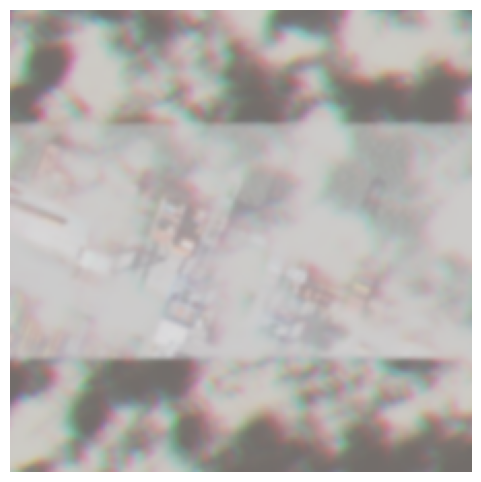

In [249]:
# 1. load + to‐tensor
img = ds_train[1700]['image'].convert("RGB")
img_tensor = transforms.ToTensor()(img)        # shape [C,H,W]
img_tensor = img_tensor.unsqueeze(0)           # shape [1,C,H,W]

# assume img_tensor.shape == [1,3,H,W]
batch, channels, _, _ = img_tensor.shape

# Option A: all channels = 0.7
channel_magnitude = torch.full(
    (batch, channels, 1, 1),
    fill_value=0.8,
    dtype=torch.float32,
    device=img_tensor.device
)

# 2. simulate clouds
cloudy_tensor = scg.add_cloud_and_shadow(img_tensor,
                                         max_lvl=(0.95,1.0),
                         min_lvl=(0.5, 0.55),
                         channel_magnitude=channel_magnitude,
                         shadow_max_lvl=[0.3,0.6],
                         clear_threshold=0.0,
                         noise_type = 'perlin',
                         const_scale=True,
                         decay_factor=1,
                         locality_degree=1,
                         channel_offset=2,
                         channel_magnitude_shift=0.05,
                         blur_scaling=2.0,
                         cloud_color=True,
                         return_cloud=False
                        )

# 3. back to PIL + plot
cloudy_pil = transforms.ToPILImage()(cloudy_tensor.squeeze(0))
plt.figure(figsize=(6,6))
plt.imshow(cloudy_pil)
plt.axis('off')
plt.show()

In [250]:
# Use the OpenAI image quality method to get the response for the image with added clouds

# Assume 'cloudy_pil' is the processed PIL image with clouds (from previous cell)
quality_response = get_quality({"image": cloudy_pil})

print("OpenAI image quality score for cloudy image:", quality_response)

OpenAI image quality score for cloudy image: 0.15


In [ ]:
# Train and Evaluate Models with Regularization (ResNet18, MobileNetV3, EfficientNetB0) and Save Results and Model to Disk
# Inspect Results with Regularization
# Train and Evaluate Regressor for Quality Scores and Save Results and Model to Disk
# Inspect Results of Regressor for Quality Scores
# Global Conformal Prediction
# Our Conformal Prediction Quality-Bucket-Based Method

In [ ]:
# Ablation Studies Combinations:
# - ResNet18, MobileNetV3, EfficientNetB0
# - Regularization/Quality Scores: With, Without
# - Conformal Prediction: Global, Quality-Bucket-Based

In [ ]:
# TODO maybe some more distortions to the data? Or only on x% of the data so that we can see the effect of the distortions on the model performance?
# TODO that is, preferably we want to see that the model performs better on images with higher image quality scores to help our argument!
# TODO maybe compare how chatgpt scores on the original images vs. the distorted ones?
# TODO the problem is that for some classes the images are already quite distorted but in a way to still show the characteristics of the ship class
# TODO thus the model is still able to classify them correctly, but the image quality is low

In [ ]:
# TODO why is ds somewhere overwritten with only one of the splits? This needs to be fixed!

In [ ]:
# TODO do I still need blurring?
# TODO do I still need haze?
# TODO how to systematically preprocess the dataset now? Maybe leave a percentage of the dataset untouched and only apply distortions to the rest?
# TODO also do it similar for each class.
# TODO do we really want to do the buckets? Or we just classify the image quality already into qualitative buckets instead of a quantitative score?
# TODO this would make many things easier and we dont have to do the regression or optimization and can keep them for another time

In [ ]:
# TODO we need to have a look also at the distribution of the image qualities and how they are distributed across the classes

In [ ]:
# TODO Remove the part where we exclude images due to similarity
# TODO 

In [ ]:
# TODO custom dataset is needed for with regularization because it needs to be preprocessed with the quality scores

# 4) Weighted sampler for training
train_labels = train_ds.labels
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = np.array([class_weights[l] for l in train_labels])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

In [ ]:
# Cell: 2. Train/validation/test split and CNN regressor for quality

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image

# Load qualities and image paths
df = pd.read_csv("image_qualities.csv")

# Define transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Dataset for regression
class QualityDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        x = self.transform(img)
        y = torch.tensor([row["quality"]], dtype=torch.float32)
        return x, y

# Create full dataset
full_ds = QualityDataset(df, transform)

# Split: 80% train, 10% val, 10% test
n = len(full_ds)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

# Model: pretrained ResNet18 with regression head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = models.resnet18(pretrained=True)
backbone.fc = nn.Sequential(
    nn.Linear(backbone.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
model = backbone.to(device)

# Loss & optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
best_val_loss = float('inf')
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= n_train

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item() * x_batch.size(0)
    val_loss /= n_val

    print(f"Epoch {epoch+1}: Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}")

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "quality_regressor_best.pth")

# Test set evaluation
model.load_state_dict(torch.load("quality_regressor_best.pth", map_location=device))
model.eval()
test_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        test_loss += criterion(model(x_batch), y_batch).item() * x_batch.size(0)
test_loss /= n_test
print(f"Test MSE={test_loss:.4f}")

